# Recitation 2 - Comparing Formulations

In today's recitation, we will build different formulations of the same problem, and explore the computational implications.

## Learning objectives
By the end of today's recitation, students will be able to:
- Compare the linear relaxation of two formulations of the same problem and test the computational times of both formulations using JuMP with Gurobi
- Implement a row generation algorithm in JuMP using lazy constraints for solving the traveling salesman problem

## amoon summary
- facility location
buildtime is smaller for AFL but opttime is much longer 

- lot sizing
min cost (setup $c_t x_t$ + production $p_t y_t$+ holding $h_t s_t$ 성필홍) and its two formulations one with additional explicit structure $q_st$ (~ x_iq, y_q from hw1.3, ) is tighter. But before, we need tight bound for $M_s = \sigma_{t=s}^{T}d_t, N_t = d_t$ which are needed to prove second formulation is tighter. expected as auxiliary variable (higher dimension) can be used to construct lower dim polytope

better heuristic sol with presolve (999 to 878)
```
Optimize a model with 25500 rows, 25050 columns and 75000 nonzeros
Model fingerprint: 0x83c02238
Variable types: 0 continuous, 25050 integer (25050 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 999.3253001
Presolve time: 0.05s
Presolved: 25500 rows, 25050 columns, 75000 nonzeros
Variable types: 0 continuous, 25050 integer (25050 binary)
Found heuristic solution: objective 878.6356621

Root relaxation: objective 1.558382e+02, 5559 iterations, 0.03 seconds (0.06 work units)
...
Optimal solution found (tolerance 1.00e-04)
Best objective 1.558381904905e+02, best bound 1.558381904905e+02, gap 0.0000%
```

the first can be easily constructe


- TSP
-- MTZ < CUTSET = SUB
-- MTZ: u_i - u_j -1 < (n-2)(1-x_ij) - futile if x_ij = 1 find permutation (order of the node) instead of eliminate subtour
-- implement cutset only when we need
-- lazy constraints in callback function

First, we load packages.

In [1]:
using JuMP, Gurobi
using DataFrames, CSV, Combinatorics
using Random
using LinearAlgebra
using Distances
using Plots, StatsPlots
using Suppressor

If there are any packages you have not used before, add them using the Pkg module.

In [2]:
using Pkg
Pkg.add("StatsPlots")
Pkg.add("Random")
Pkg.add("Combinatorics")
Pkg.add("Distances")
Pkg.add("Suppressor")

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


## Part 1: Facility location

### 1.1 Problem setup

We are now ready to formulate our first integer optimization problem. The facility location problem takes as inputs two sets and two parameters:
- Sets:
    - facilities $j\in \mathcal{J}=\{1,\ldots,n\}$
    - customers $i\in \mathcal{I}=\{1, \ldots, m\}$
- Parameters:
    - $d_{ij}$: distance from customer $i$ to facility $j$
    - $c_j$: cost of facility $j$   

<img src="extra/facilitylocation.png" style="width:700px"/>
    
Let's define the size of the problem.

In [3]:
n = 50      #facilities
m = 500     #customers

500

In real-life, we would have data on the location of facilities and customers. For simplicity, we assume that the facilities and customers are uniformly sampled over the unit square $[0,1]^2$. The first column of the following arrays denotes the x coordinate, and the second column denotes the y coordinate.

In [4]:
facilities = rand(MersenneTwister(0), n, 2);
customers = rand(MersenneTwister(0), m, 2); # notice we add a semicolon to suppress Jupyter output

We can now define the distance matrix:

In [5]:
dist = Distances.pairwise(Euclidean(), customers, facilities, dims = 1)
@show size(dist);

size(dist) = (500, 50)


Finally, we sample a vector of facility costs uniformly between 10 and 20:

In [6]:
c = rand(MersenneTwister(0), n) * 10 .+ 10;

### 1.2 Formulations

We covered two formulations of the problem in class, one with many constraints but a tight formulation, the other with fewer constraints but a less tight formulation. 

#### Formulation 1 - Less tight formulation, fewer constraints (Aggregate Facility Location)

\begin{align*}
        \min        &   \quad\sum_{j=1}^nc_jy_j+\sum_{i=1}^m\sum_{j=1}^nd_{ij}x_{ij}  \\
        \text{s.t.} &   \quad\sum_{j=1}^nx_{ij}=1,\ \forall i \\
                    &   \quad{\color{Veronared}\sum_{i=1}^mx_{ij}\leq my_j,\ \forall j} \\
                    &   \quad x_{ij}\in\{0,1\},\ y_j\in\{0,1\}
\end{align*}

#### Formulation 2 - Tight formulation, more constraints

\begin{align*}
        \min        &   \quad\sum_{j=1}^nc_jy_j+\sum_{i=1}^m\sum_{j=1}^nd_{ij}x_{ij}  \\
        \text{s.t.} &   \quad\sum_{j=1}^nx_{ij}=1,\ \forall i \\
                    &   \quad {\color{Veronared}x_{ij}\leq y_j,\ \forall i,j} \\
                    &   \quad x_{ij}\in\{0,1\},\ y_j\in\{0,1\}
    \end{align*}
    
On the left is a projection of the feasible region of the LP relaxation of formulation 1 (aggregated facility location problem). While on the right is a projection of the feasible region of the LP relaxation of the formulation 2.

<img src="extra/flpolyhedra.png" style="width:800px"/>

Time to implement!

In [7]:
"Build facility location model 1"
function facility_model_1(distance::Matrix, cost::Vector)
    # extract problem dimensions from distance matrix and verify coherence of input data
    m, n = size(distance)
    @assert length(cost) == n
    
    model = Model(Gurobi.Optimizer)
    set_time_limit_sec(model, 1800)
    
    # VARIABLES
    @variable(model, y[1:n], Bin) # setup decision variables
    @variable(model, x[1:m, 1:n], Bin) # assignment decision variables

    # CONSTRAINTS
    @constraint(
        model, 
        serve_every_customer[i = 1:m], 
        sum(x[i, j] for j = 1:n) == 1
    )
    @constraint(
        model, 
        only_serve_from_open_facility[j=1:n], 
        sum(x[i, j] for i=1:m) <= m * y[j]
    )
    
    # OBJECTIVE
    @objective(
        model, 
        Min, 
        sum(cost[j] * y[j] for j = 1:n) # setup costs
        + sum(distance[i, j] * x[i, j] for i=1:m, j=1:n) # assignment costs
    )
    
    return model, x, y
end

facility_model_1

In [8]:
"Build facility location model 2"

function facility_model_2(distance::Matrix, cost::Vector)
    # extract problem dimensions from distance matrix and verify coherence of input data
    m, n = size(distance)
    @assert length(cost) == n
    
    model = Model(Gurobi.Optimizer)
    set_time_limit_sec(model, 1800)
    
    # VARIABLES
    @variable(model, y[1:n], Bin) # setup decision variables
    @variable(model, x[1:m, 1:n], Bin) # assignment decision variables

    # CONSTRAINTS
    @constraint(
        model, 
        serve_every_customer[i = 1:m], 
        sum(x[i, j] for j = 1:n) == 1
    )
    @constraint(
        model, 
        only_serve_from_open_facility[i = 1:m, j=1:n], 
        x[i, j] <= y[j]
    )
    
    # OBJECTIVE
    @objective(
        model, 
        Min, 
        sum(cost[j] * y[j] for j = 1:n) # setup costs
        + sum(distance[i, j] * x[i, j] for i=1:m, j=1:n) # assignment costs
    )
    
    return model, x, y
end

facility_model_2 (generic function with 1 method)

Now we can call our function to build the models with our sampled data, then solve and report the elapsed time.

In [9]:
buildtime1 = @elapsed model1, x1, y1 = facility_model_1(dist, c);
solvetime1 = @elapsed optimize!(model1);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-18
Set parameter TimeLimit to value 1800
Set parameter TimeLimit to value 1800
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 550 rows, 25050 columns and 50050 nonzeros
Model fingerprint: 0xd80d1ad7
Variable types: 0 continuous, 25050 integer (25050 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [2e-03, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 999.3253001
Presolve time: 0.03s
Presolved: 550 rows, 25050 columns, 50050 nonzeros
Variable types: 0 continuous, 25050 integer (25050 binary)
Found heuristic solution: objective 878.6356621

Root relaxation: objective 5.155704e+01, 616 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |

In [10]:
buildtime2 = @elapsed model2, x2, y2 = facility_model_2(dist, c);
solvetime2 = @elapsed optimize!(model2);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-18
Set parameter TimeLimit to value 1800
Set parameter TimeLimit to value 1800
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 25500 rows, 25050 columns and 75000 nonzeros
Model fingerprint: 0x83c02238
Variable types: 0 continuous, 25050 integer (25050 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 999.3253001
Presolve time: 0.05s
Presolved: 25500 rows, 25050 columns, 75000 nonzeros
Variable types: 0 continuous, 25050 integer (25050 binary)
Found heuristic solution: objective 878.6356621

Root relaxation: objective 1.558382e+02, 5559 iterations, 0.03 seconds (0.06 work units)

    Nodes    |    Current Node

We can confirm that the two formulations arrive at the same objective and build the same facilities:

In [11]:
println("Formulation 1 objective: \t\t$(objective_value(model1))")
println("Formulation 1 facilities built: \t$(findall(x -> (x > 0.5), value.(model1[:y])))")

println("Formulation 2 objective: \t\t$(objective_value(model2))")
println("Formulation 2 facilities built: \t$(findall(x -> (x > 0.5), value.(model1[:y])))")


Formulation 1 objective: 		155.83819049048648


Formulation 1 facilities built: 	[15, 17, 20, 30]
Formulation 2 objective: 		155.83819049048648
Formulation 2 facilities built: 	[15, 17, 20, 30]


However, it takes far longer to solve the model in the first formulation compared to the second formulation:

In [12]:
println("Time taken for formulation 1 (model building):\t$(buildtime1)")
println("Time taken for formulation 1 (model solving):\t$(solvetime1)")
println("Time taken for formulation 2 (model building):\t$(buildtime2)")
println("Time taken for formulation 2 (model solving):\t$(solvetime2)")

Time taken for formulation 1 (model building):	2.208773125
Time taken for formulation 1 (model solving):	4.7978245
Time taken for formulation 2 (model building):	0.113066584
Time taken for formulation 2 (model solving):	0.131882417


In fact, this gap increases with larger $n$, as we can observe below:

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-18
Set parameter TimeLimit to value 1800


Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-18
Set parameter TimeLimit to value 1800


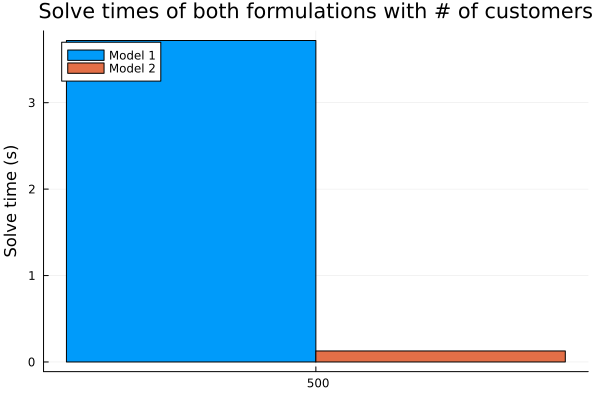

In [13]:
plotdata = []
m_range = [500] #, 1000, 2000]
for (n, m) in Iterators.product(
    [50], 
    m_range,
)
    facilities = rand(MersenneTwister(0), n, 2)
    customers = rand(MersenneTwister(0), m, 2)
    dist = Distances.pairwise(Euclidean(), customers, facilities, dims = 1)
    c = rand(MersenneTwister(0), n) * 10 .+ 10
    buildtime1 = @elapsed model1, _, _ = facility_model_1(dist, c)
    solvetime1 = @elapsed @suppress optimize!(model1)
    buildtime2 = @elapsed model2, _, _ = facility_model_2(dist, c)
    solvetime2 = @elapsed @suppress optimize!(model2)
    push!(plotdata, (
        buildtime1 = buildtime1, 
        solvetime1 = solvetime1, 
        buildtime2 = buildtime2, 
        solvetime2 = solvetime2, 
    ))
end
df = DataFrame(plotdata)
groupedbar(
    repeat(lpad.(string.(m_range), 4), outer = 2), 
    vcat(df[!, :solvetime1], df[!, :solvetime2]),
    group = repeat(["Model 1", "Model 2"], inner = length(m_range)),
    ylabel = "Solve time (s)",
    # yscale = :log10,
    title = "Solve times of both formulations with # of customers",
    legend = :topleft,
)



In [14]:
solvetime1 = @elapsed optimize!(model1);
```
Optimize a model with 550 rows, 25050 columns and 50050 nonzeros
Variable types: 0 continuous, 25050 integer (25050 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [2e-03, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 999.3253001
Presolve time: 0.03s
Presolved: 550 rows, 25050 columns, 50050 nonzeros
Found heuristic solution: objective 878.6356621 (after presolve)
Root relaxation: objective 5.155704e+01, 616 iterations, 0.00 seconds (0.00 work units)
Optimal solution found (tolerance 1.00e-04)
Best objective 1.558381904905e+02, best bound 1.558381904905e+02, gap 0.0000%
User-callback calls 4148, time in user-callback 0.00 sec
```
solvetime2 = @elapsed optimize!(model2);
```
Optimize a model with 25500 rows, 25050 columns and 75000 nonzeros
Variable types: 0 continuous, 25050 integer (25050 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  ...(same)...
Presolve time: 0.05s
Presolved: 25500 rows, 25050 columns, 75000 nonzeros
Found heuristic solution: objective 878.6356621 (after presolve)
Root relaxation: objective 1.558382e+02, 5559 iterations, 0.03 seconds (0.06 work units)
...(same)...
User-callback calls 161, time in user-callback 0.00 sec
```

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 550 rows, 25050 columns and 50050 nonzeros
Model fingerprint: 0xd80d1ad7
Variable types: 0 continuous, 25050 integer (25050 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [2e-03, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolved: 550 rows, 25050 columns, 50050 nonzeros

Continuing optimization...


Explored 1668 nodes (74583 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 10: 155.838 161.175 163.319 ... 999.325

Optimal solution found (tolerance 1.00e-04)
Best objective 1.558381904905e+02, best bound 1.558381904905e+02, gap 0.0000%

User-callback calls 26, time in user-callback 0.00 sec


LoadError: LoadError: parsing command `Optimize a model with 550 rows, 25050 columns and 50050 nonzeros
Variable types: 0 continuous, 25050 integer (25050 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [2e-03, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 999.3253001
Presolve time: 0.03s
Presolved: 550 rows, 25050 columns, 50050 nonzeros
Found heuristic solution: objective 878.6356621 (after presolve)
Root relaxation: objective 5.155704e+01, 616 iterations, 0.00 seconds (0.00 work units)
Optimal solution found (tolerance 1.00e-04)
Best objective 1.558381904905e+02, best bound 1.558381904905e+02, gap 0.0000%
User-callback calls 4148, time in user-callback 0.00 sec
`: special characters "#{}()[]<>|&*?~;" must be quoted in commands
in expression starting at /Users/hyunjimoon/Dropbox (MIT)/tolzul/BayesSD/code/pipeline/prescriptive/IP/recitation/Recitation 2/Recitation-2-Complete.ipynb:2

## Part 2: TSP

In the traveling salesman problem, we have $n$ locations, or "cities", indexed by $[n]=\{1,\ldots,n\}$ with $d_{ij}$ denoting the distance between location $i$ and location $j$.

The goal is to find a tour that visits each location exactly once, while minimizing total distance traveled.

### 2.1 Problem setup

We have a few TSP instances saved in the `tsp` directory. The data are stored as ASCII text files, which we can read as follows.

In [15]:
file = open("tsp/berlin52.tsp");
data = readlines(file)
data[1:10]

10-element Vector{String}:
 "NAME: berlin52"
 "TYPE: TSP"
 "COMMENT: 52 locations in Berlin (Groetschel)"
 "DIMENSION: 52"
 "EDGE_WEIGHT_TYPE: EUC_2D"
 "NODE_COORD_SECTION"
 "1 565.0 575.0"
 "2 25.0 185.0"
 "3 345.0 750.0"
 "4 945.0 685.0"

The first few lines describe the file and the problem type, and the following lines list the `(x,y)` coordinates of each point in a grid. We want to extract the coordinates and define a distance matrix. The function below is one way to do this, but there are many others.

In [16]:
function get_distances(filename)
    file = open(filename)
    data = readlines(file)
    close(file)
    
    # get useful lines
    dimension_line = findfirst(x -> occursin("DIMENSION", x), data)
    metric_line = findfirst(x -> occursin("EDGE_WEIGHT_TYPE", x), data)
    first_data_line = findfirst(x -> occursin("NODE_COORD_SECTION", x), data) + 1
    last_data_line = findfirst(x -> occursin(r"EOF", x), data) - 1
    
    # extract dimension
    n = parse(Int64, match(r"[0-9]+", data[dimension_line]).match)
    
    # check metric is Euclidean 2D
    occursin("EUC_2D", data[metric_line]) || error("Unsupported metric type")
    
    # Create coordinates
    coords = zeros(n, 2)
    for line in data[first_data_line:last_data_line]
        temp = split(line)
        coords[parse(Int64,temp[1]),:] = [parse(Float64,temp[2]) parse(Float64,temp[3])]
    end
    
    # Create distance matrix
    distances = Distances.pairwise(Euclidean(), coords, dims = 1)
    
    return distances
end

get_distances (generic function with 1 method)

We can now use our shiny new `get_distances` function to convert a TSP text file to a distance matrix. We can visually check the matrix is 52x52, is symmetric, has nonnegative values, and zeros on the diagonal.

In [17]:
get_distances("tsp/berlin52.tsp")

52×52 Matrix{Float64}:
    0.0      666.108   281.114   395.601   …   217.083   789.383  1220.46
  666.108      0.0     649.327  1047.09        596.259  1421.56   1716.05
  281.114    649.327     0.0     603.511       463.249   995.314  1483.59
  395.601   1047.09    603.511     0.0         477.624   397.02    908.639
  291.204    945.145   508.945   104.403       386.685   499.925   984.441
  326.267    978.085   542.517    69.6419  …   413.793   464.57    954.895
  640.8       45.0     610.574  1026.36        584.637  1405.08   1715.07
  426.878    956.151   308.058   525.0         643.817   860.145  1430.47
  600.187   1134.96    485.644   611.003       815.138   883.233  1486.78
  561.471   1132.98    487.263   533.901       771.962   800.078  1404.04
    ⋮                                      ⋱               ⋮      
  154.434    744.883   434.195   307.002       175.0     678.399  1070.81
  240.208    823.286   219.829   411.096       456.755   790.142  1314.96
  279.866    859.08

### 2.2 Formulations

#### Base formulation

$$\begin{align}
\min\quad & \sum_{i=1}^n\sum_{j=1}^n d_{ij}x_{ij}\\
\text{s.t.}\quad & \sum_{i=1}^n x_{ij}=1 & \forall j\in[n]\\
&\sum_{j=1}^nx_{ij} =1 & \forall i\in[n]\\
&x_{ii}=0 & \forall i\in[n]\\
& x_{ij}\in\{0,1\}&\forall i, j \in [n]
\end{align}$$

_Note: even though our distance matrix is symmetric, it is slightly easier to implement a more general formulation where we do not assume this property. If we know our distance matrix is symmetric, we can cut the number of variables in half by only defining $x_{ij}$ for $i < j$ (i.e. not defining both $x_{12}$ and $x_{21}$), but this is beyond the scope of this recitation._

In [18]:
"Construct TSP pre-model, without cycle elimination mechanism"
function prebuild_tsp(dist::Matrix{Float64}, time_limit_seconds)
    
    n = size(dist, 1)
    
    # Definition of model
    model = Model(Gurobi.Optimizer)
    set_time_limit_sec(model, time_limit_seconds)
    
    # Main variable: x_ij=1 if the tour visits i and j in that order, 0 otherwise
    @variable(model, x[1:n, 1:n], Bin)
    
    # Objective: minimizing the total cost (distance) of the tour
    @objective(
        model, 
        Min, 
        sum(dist[i, j] * x[i, j] for i = 1:n, j = 1:n)
    )
    
    # SHARED CONSTRAINTS
    @constraint(
        model, 
        no_self_edges[i = 1:n], 
        x[i,i] == 0
    )
    @constraint(
        model, 
        exactly_one_successor[i = 1:n], 
        sum(x[i, j] for j = 1:n) == 1
    )
    @constraint(
        model, 
        exactly_one_predecessor[j = 1:n], 
        sum(x[i, j] for i = 1:n) == 1
    )
    
    return model, x
end

prebuild_tsp

### What is the issue with this formulation?

Consider the two solutions below. Are each of them feasible?

<img src="extra/basetspsolutions.png" style="width:800px"/>

#### Issues with the formulation

The formulation we've built so far is nice, but it has one big flaw! It doesn't ensure that every city must be part of the same tour.

For instance, the second example above involves two tours that are not connected.

We need to somehow **eliminate these "subtours"**.

## Attempt 1: MTZ formulation (compact)

This formulation eliminates subtours using a $u_i$ variable for each node $i$, which defines the "order" of the visit starting from node 1 ($u_1=1$). More precisely, we impose the following constraints:

$u_1=1$

$2\le u_i \le n \quad\forall i=2, \ldots, n$

$u_j \ge u_i + 1 - (n-1)(1-x_{ij}) \quad \forall i, j \in \{2,\ldots,n\}$

The first two are straightforward. What does the third one mean?

<img src="extra/mtz.png" style="width:800px"/>

- If $x_{ij}=1$, then we impose that $u_j\ge u_i +1$ (the order of $j$ is at least 1 + the order of $i$). Since all $u_i$ are upper-bounded by $n$, this leads to the order of $j$ being exactly 1 + the order of $i$).
- If $x_{ij}=0$, then we impose that $u_j\ge u_i + 2 - n$. Since $u_i$ is at most $n$, in the worst case we impose $u_j\ge 2$ which holds as long as $j>1$ (recall our convention that $u_1=1$). So $x_{ij}=0$ effectively "turns off" the constraint.

We implement the MTZ formulation by appending these constraints to the core assignment model.

In [19]:
"Solve TSP using MTZ formulation, return runtime and objective"
function solveMTZ(dist::Matrix; time_limit_seconds::Real=1800)
    
    model, x = prebuild_tsp(dist, time_limit_seconds)
    set_time_limit_sec(model, time_limit_seconds)
    
    n = size(dist, 1)
    
    # Lower bound: 1 for node 1, 2 for all other nodes
    lb = [1; 2 * ones(n-1)]
    # Upper bound: 1 for node 1, n for all other nodes
    ub = [1; n * ones(n-1)]
    
    # We define the u variable with lower and upper bounds, ensuring in particular that u_1=1
    @variable(
        model, 
        lb[i] <= u[i = 1:n] <= ub[i]
    )
    
    # Constraint
    @constraint(
        model, 
        [i = 2:n, j = 2:n], 
        u[i] - u[j] + 1 <= (n-1) * (1 - x[i, j])
    )
   
    # We then solve the model and store the runtime
    start = time()
    optimize!(model)
    solvetime = time() - start
    return solvetime, objective_value(model)
end

solveMTZ

Let's try it!

In [20]:
dist52 = get_distances("tsp/berlin52.tsp");
solvetime52_MTZ, obj52_MTZ = solveMTZ(dist52);
println("Runtime: \t$solvetime52_MTZ seconds")
println("Objective:\t$obj52_MTZ")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-18
Set parameter TimeLimit to value 1800
Set parameter TimeLimit to value 1800
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 2757 rows, 2756 columns and 13161 nonzeros
Model fingerprint: 0xabecf421
Variable types: 52 continuous, 2704 integer (2704 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [2e+01, 2e+03]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 103 rows and 53 columns
Presolve time: 0.01s
Presolved: 2654 rows, 2703 columns, 12954 nonzeros
Variable types: 51 continuous, 2652 integer (2652 binary)
Found heuristic solution: objective 30198.641923
Found heuristic solution: objective 27757.818031

Root relaxation: objective 6.318826e+03, 195 iterations, 0.00 seconds (0.00 work un

Let's try it on a larger instance now.

In [21]:
dist76 = get_distances("tsp/pr76.tsp");
solvetime76_MTZ, obj76_MTZ = solveMTZ(dist76, time_limit_seconds=60)
println("Runtime: $solvetime76_MTZ seconds")
println("Objective: $obj76_MTZ")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-18
Set parameter TimeLimit to value 60
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 5853 rows, 5852 columns and 28353 nonzeros
Model fingerprint: 0x9c0da5a0
Variable types: 76 continuous, 5776 integer (5776 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [3e+02, 2e+04]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 151 rows and 77 columns
Presolve time: 0.02s
Presolved: 5702 rows, 5775 columns, 28050 nonzeros
Variable types: 75 continuous, 5700 integer (5700 binary)

Root relaxation: objective 7.766213e+04, 318 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

On 52 cities, we solve in about one second. On 76 cities, we are much slower! Even after 60 seconds, our objective gap is still not zero. Clearly this will not scale to hundreds of cities.

## Attempt 2: combinatorial formulation (cutset)

OK, so MTZ is a bit of a dud (no offense). Can we do better? Yes, provided we're not afraid of large numbers.

*Intuition:* since we seem to dislike subtours so much, let's write a specific constraint for every possible subtour, preventing it from existing.

One way to do this is the following pair of "cutset" constraints:

$$\sum_{i\in S}\sum_{j\notin S} x_{ij}\ge 1 \quad\forall S\subset V, S\neq\emptyset, V$$

$$\sum_{i\notin S}\sum_{j\in S} x_{ij}\ge 1 \quad\forall S\subset V, S\neq\emptyset, V$$

_What's going on here?_ For a subset of nodes $S$, the constraints above ensure that there is at least one edge leaving the subset $S$, and at least another edge entering the subset $S$.

![](extra/cut-set-diagram.png)

Unfortunately, a direct implementation is simply impossible, even for small-scale instances. Indeed, the number of subsets of $\{1,n\}$ is equal to $2^n$. For $n=52$, this means $4.5\cdot 10^{15}$ -- clearly impossible with our computer's memory.

Instead, we will add constraints ***only when we need them***. 

<img src="extra/rowgeneration.png" style="width:800px"/>

We have two options:
1. We will solve the model naively, without subtour elimination constraints, and add constraints that are violated by the incumbent solution.

2. We can also define **lazy constraints** in a callback function. This is a bit harder, but the idea is to give the constraints to the solver, and the solver will use them as needed through the branch-and-cut process. Specifically, the solver will keep the constraints in a "pool". As solutions are generated (in the branching tree), the solver checks which constraints are violated and adds them to the active formulation. Hence, the name "lazy" constraints because we let the solver use them as needed.

Either way, we need to write a function to find a subtour in a candidate solution. If we were trying to make our code as efficient as possible, our best bet would be to write this function ourselves. In this recitation, we're going to pick an easier route, using the `Graphs` package.

In [22]:
#Pkg.add("Graphs")
using Graphs

The `Graphs` package is a way to easily work with graphs in Julia.

Given a solution $\boldsymbol{x}^*$, we can define the _induced_ graph $G(\boldsymbol{x}^*)$ as the graph with one node per TSP node, and an edge between each pair of nodes $(i,j)$ for which $x^*_{ij}=1$.

We know that a graph induced by a feasible solution will have exactly one edge into each node, and one edge out of each node. There is therefore a one-to-one mapping between subtours in the induced TSP graph and connected components of the induced graph.

### Function to find subtours

In [24]:
"""
    Given the induced graph as an adjacency list (i.e., next[i] is the next node to visit after node i),
        compute all subtours.
    Return them as a list of lists of nodes in the same component
"""
function find_subtours(next::Vector{Int})
    n = length(next)
    g = Graphs.DiGraph(n)
    for i = 1:n
        Graphs.add_edge!(g, i, next[i])
    end
    components = Graphs.strongly_connected_components(g)
    return sort(components, by=length)
end

find_subtours

Let's try using this function

In [25]:
dist52 = get_distances("tsp/berlin52.tsp")
model, x = prebuild_tsp(dist52, 60)
optimize!(model)
next = [findfirst(x -> x > 0.5, value.(x[i, :])) for i = 1:size(x, 1)]
subtours = find_subtours(next)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-18
Set parameter TimeLimit to value 60
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 156 rows, 2704 columns and 5460 nonzeros
Model fingerprint: 0xf466f051
Variable types: 0 continuous, 2704 integer (2704 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 30640.309698
Presolve removed 52 rows and 52 columns
Presolve time: 0.00s
Presolved: 104 rows, 2652 columns, 5304 nonzeros
Variable types: 0 continuous, 2652 integer (2652 binary)

Root relaxation: objective 6.285960e+03, 87 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bound

23-element Vector{Vector{Int64}}:
 [1, 22]
 [4, 25]
 [8, 41]
 [9, 10]
 [11, 52]
 [12, 51]
 [13, 14]
 [16, 29]
 [19, 45]
 [20, 50]
 ⋮
 [32, 49]
 [33, 43]
 [37, 38]
 [39, 40]
 [44, 46]
 [2, 7, 42]
 [5, 6, 15]
 [34, 36, 35]
 [3, 18, 31, 21, 17]

We notice two things here:

1. We have a lot of subtours of length 2 - this is due to the directed formulation, different from the undirected formulation in lecture.

2. We have lost some information by using connected components, namely the order of the cycle. But it's ok, because the cutset constraints doesn't care about the order of the cycle anyway.

We also notice we have quite a few subtours to eliminate. For the subtours of length 2, we could decide to eliminate all of them at once, or to eliminate them as they come up. We can even see which approach is faster!

## First, an iterative approach - Gurobi solves, then we check solution and add constraints

In [26]:
"Solve the TSP using an iterative approach"
function solve_iterative(
    dist::Matrix; 
    time_limit_seconds::Real = 1800,                     
    eliminate_length_2::Bool=false,
    verbose::Bool = true,
)    
    # We first solve the model without any subtour elimination consideration
    model, x = prebuild_tsp(dist, time_limit_seconds)
    n = size(dist, 1)
    if eliminate_length_2
        @constraint(model, no_length_2[i = 1:n, j = 1:n], x[i, j] + x[j, i] <= 1)
    end
    if !verbose
        set_optimizer_attribute(model, "OutputFlag", 0)
    end
    
    start = time()
    optimize!(model)

    while true
        # We store the incumbent solution
        next = [findfirst(x -> x > 0.5, value.(x[i, :])) for i = 1:n]
        # Note: checking for >0.5 is conservative (x is binary!) but it avoids numerical errors
        
        subtours = find_subtours(next)
        println("Found $(length(subtours)) subtours after $(time() - start) seconds")
        
        if length(subtours) == 1 # only one cycle, the TSP solution
            solvetime = time() - start
            return solvetime, objective_value(model)
        else
            # eliminate subtours
            for subtour in subtours
                @constraint(model, sum(x[i, j] for i=subtour, j=setdiff(1:n, subtour)) >= 1)
                @constraint(model, sum(x[i, j] for i=setdiff(1:n, subtour), j=subtour) >= 1)
            end
        end
        
        # Optimize
        optimize!(model)
        solvetime = time() - start
        if solvetime > time_limit_seconds 
            return solvetime, objective_value(model)
        end
    end
end

solve_iterative

In [27]:
solvetime52_iterative, obj52_iterative = solve_iterative(dist52, verbose=false, eliminate_length_2=false)
println("Runtime: $solvetime52_iterative seconds")
println("Objective: $obj52_iterative")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-18
Set parameter TimeLimit to value 1800
Set parameter TimeLimit to value 1800
Found 23 subtours after 0.00897216796875 seconds


Found 9 subtours after 0.14890313148498535 seconds
Found 1 subtours after 0.16391801834106445 seconds
Runtime: 0.16407108306884766 seconds
Objective: 7544.365901904089


Now let's try that 76-city instance. Remember it didn't solve in one minute using the MTZ formulation.

In [28]:
solvetime76_iterative, obj76_iterative = solve_iterative(dist76, verbose=false, eliminate_length_2=false)
println("Runtime: $solvetime76_iterative seconds")
println("Objective: $obj76_iterative")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-18
Set parameter TimeLimit to value 1800
Set parameter TimeLimit to value 1800
Found 36 subtours after 0.018546104431152344 seconds


Found 11 subtours after 0.1592540740966797 seconds


Found 10 subtours after 0.29967212677001953 seconds


Found 7 subtours after 0.4589371681213379 seconds


Found 5 subtours after 0.6208541393280029 seconds


Found 4 subtours after 0.9654510021209717 seconds


Found 3 subtours after 1.2577540874481201 seconds


Found 4 subtours after 1.5931119918823242 seconds


Found 4 subtours after 2.026128053665161 seconds


Found 4 subtours after 2.6347200870513916 seconds


Found 3 subtours after 3.640665054321289 seconds


Found 5 subtours after 5.815198183059692 seconds


Found 1 subtours after 9.415953159332275 seconds
Runtime: 9.416145086288452 seconds
Objective: 108159.43827413766


Let's try to solve even larger instances! This one has 280 locations.

In [29]:
dist280 = get_distances("tsp/a280.tsp")
solvetime280_iterative, obj280_iterative = solve_iterative(dist280, verbose=false);
println("Runtime: $solvetime280_iterative seconds")
println("Objective: $obj280_iterative")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-18
Set parameter TimeLimit to value 1800
Set parameter TimeLimit to value 1800
Found 129 subtours after 0.2233750820159912 seconds


Found 38 subtours after 1.518462896347046 seconds


Found 33 subtours after 2.991386890411377 seconds


Found 20 subtours after 4.577351093292236 seconds


Found 10 subtours after 6.316915988922119 seconds


Found 10 subtours after 8.711941957473755 seconds


Found 8 subtours after 10.991229057312012 seconds


Found 6 subtours after 13.049967050552368 seconds


Found 6 subtours after 15.536488056182861 seconds


Found 4 subtours after 17.907273054122925 seconds


Found 2 subtours after 20.237480878829956 seconds


Found 5 subtours after 22.863322973251343 seconds


Found 2 subtours after 26.06670594215393 seconds


Found 3 subtours after 28.794981002807617 seconds


Found 1 subtours after 32.40335488319397 seconds
Runtime: 32.40352702140808 seconds
Objective: 2586.769647563161


## Now, let's use lazy constraints - Gurobi uses our cuts in the branch-and-cut tree

**1. Initialize our base formulation for the TSP as usual** (i.e. no subtour elimination)

Also, be sure turn on the `LazyConstraints` parameter in the Gurobi optimizer!

In [30]:
n = size(dist52, 1)
model, x = prebuild_tsp(dist52, 60)
set_optimizer_attribute(model, "LazyConstraints", 1);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-18
Set parameter TimeLimit to value 60
Set parameter LazyConstraints to value 1


**2. Define our "callback" function**

Whenever Gurobi finds a new integer feasible solution in the branch-and-cut tree, it will run this callback procedure. The procedure gets the solution at the current node (`x_val`), runs our `find_subtours` function on the solution to identify existing subtours, then adds the corresponding constraints. The difference between this and our previous approach is that instead of solving the problem to optimality before adding our subtour constraints, we add them at nodes inside the branch-and-cut tree. 

In [31]:
function our_callback_function(cb_data, cb_where::Cint)
    
    #Run only when we have found a new integer feasible solution
    if cb_where == GRB_CB_MIPSOL
        Gurobi.load_callback_variable_primal(cb_data, cb_where)
        
        #Get the value of the x-vars at the current node and process for input to our find_subtours function
        x_val = callback_value.(Ref(cb_data), x)
        x_val_next = [findfirst(z -> z > 0.5, x_val[i, :]) for i = 1:n]
        
        #Our function to find the subtours
        subtours = find_subtours(x_val_next)

        #Add constraints for each subtour identified
        if length(subtours) > 1.01
            for subtour in subtours
                con1 = @build_constraint(sum(x[i, j] for i=subtour, j=setdiff(1:n, subtour)) >= 1)
                MOI.submit(model, MOI.LazyConstraint(cb_data), con1)
                con2 = @build_constraint(sum(x[i, j] for i=setdiff(1:n, subtour), j=subtour) >= 1)
                MOI.submit(model, MOI.LazyConstraint(cb_data), con2)
            end
        end
    end
end

our_callback_function (generic function with 1 method)

**3. Tell Gurobi to set the callback function to be `our_callback_function`, then optimize.**

In [32]:
MOI.set(model, Gurobi.CallbackFunction(), our_callback_function)
optimize!(model)
println("Runtime: ", solve_time(model))
println("Objective: ", objective_value(model))

Set parameter LazyConstraints to value 1
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 156 rows, 2704 columns and 5460 nonzeros
Model fingerprint: 0xf466f051
Variable types: 0 continuous, 2704 integer (2704 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 52 rows and 52 columns
Presolve time: 0.00s
Presolved: 104 rows, 2652 columns, 5304 nonzeros
Variable types: 0 continuous, 2652 integer (2652 binary)

Root relaxation: objective 7.223938e+03, 128 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 7223.93776    0   44     

#### Wow, that sure was fast!
Notice in the list of cutting planes at the end of the Gurobi log it shows how many of our lazy constraints were added. If we want to see specifically when and what constraints were added, we can add print statements in the callback function. 

## Wrap up

Today we solved two problems, each with two formulations. 

### Facility Location
The tighter formulation that used more constraints was the winner, beating the aggregate facility location problem. 
- **Takeaway** - Having a tight formulation matters! When you're modeling in practice (and in your final projects!), always consider whether you can make your formulation tighter by using different variables, different constraints, or additional valid inequalities. It could lead to better computational performance.

### Traveling Salesman Problem
Again, the tighter formulation with exponentially constraints was more efficient to solve when we approached it in a smart way.
- **Takeaway** - We have efficient ways to handle many problems with exponentially many constraints. Row generation (either using the iterative approach or lazy callbacks) allows us to solve large instances *exactly* without enumerating all the constraints.

Solve times in seconds:

| Cities      | MTZ - Direct | Combo - Iterative | Combo - Lazy |
| ----------- | ----------- | ----------- | ----------- |
| 52      | 1.18       | 0.19       | 0.11       |
| 76   | 60+        | 14.09       | 8.73       |
| 280   | -        | 124.08       | 58.43       |

### Question to consider: What are the parallels between today's row generation procedure and the cutting planes  discussed in lecture last week? The differences?

Big points from class discussion:
- Both row generation and cutting planes seek to add a constraint/cut to *separate* the current solution from the optimal solution we are seeking. In this way, once the constraint/cut is added, the current solution is no longer feasible and we can find a new solution.
- Cutting planes (as implemented in the Gurobi branch-and-cut algorithms) are cutting off non-integer solutions so we can add cuts to the linear programming relaxation until we find an integer feasible solution. Row generation cuts off *integer solutions* that are not actually feasible for our problem (e.g. a TSP solution with subtours). We are adding constraints until we get to a solution that satisfies all of the constraints of our problems.

-> both cutting plane and row generation x* returns optimal solution or separating hyperplane, but the separated point is noninteger (cutting plane) and integer (row generation)